In [1]:
import pandas as pd
import numpy as np
import os
import time
import gc
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from scipy import sparse

import seaborn as sns
from datetime import *
from functools import reduce
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
import datetime

import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
from catboost import CatBoostClassifier as cb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score,f1_score
from lightgbm import *
plt.rcParams['font.sans-serif'] = ['SimHei']
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_row', 300)
pd.set_option('display.float_format', lambda x: ' %.5f' % x)


C:\Users\14714\AppData\Local\Temp\ipykernel_27620\571786222.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import matplotlib
print("当前字体:", matplotlib.rcParams['font.family'])

当前字体: ['sans-serif']


In [3]:
train_dir = "./data/1_预处理/train/"
test_dir = "./data/1_预处理/A/"

特征_train_dir = "./data/2_特征/train/"
特征_test_dir = "./data/2_特征/A/"

In [4]:
# 创建 df_train 和 df_test
date_range = pd.date_range(
    start='2014-01-01 00:00:00',
    end='2019-12-31 23:00:00',  # 包含最后一日的23:00
    freq='H'  # 每小时频率
)
df_train = pd.DataFrame(date_range, columns=['时间'])
date_range = pd.date_range(
    start='2020-01-01 00:00:00',
    end='2021-12-31 23:00:00',  # 包含最后一日的23:00
    freq='H'  # 每小时频率
)
df_test = pd.DataFrame(date_range, columns=['时间'])

In [5]:
for root, ds, fs in os.walk(特征_train_dir):
    for f in fs:
        print(f)
        with open(特征_train_dir + f , "rb" ) as file :
            df_train = df_train.merge(pickle.load(file) , on='时间' , how = 'left')
print("--------------------------------------------")
for root, ds, fs in os.walk(特征_test_dir):
    for f in fs:
        print(f)
        with open(特征_test_dir + f , "rb" ) as file :
            df_test = df_test.merge(pickle.load(file) , on='时间' , how = 'left')

1~36小时滑窗特征.pkl
水文时期编码.pkl
--------------------------------------------
1~36小时滑窗特征.pkl
水文时期编码.pkl


In [11]:
df_train

时间  万安镇雨量_max_1h  万安镇雨量_max_3h  万安镇雨量_max_6h  \
0     2014-01-01 00:00:00           NaN           NaN           NaN   
1     2014-01-01 01:00:00           NaN           NaN           NaN   
2     2014-01-01 02:00:00           NaN           NaN           NaN   
3     2014-01-01 03:00:00           NaN           NaN           NaN   
4     2014-01-01 04:00:00           NaN           NaN           NaN   
...                   ...           ...           ...           ...   
52579 2019-12-31 19:00:00           NaN           NaN           NaN   
52580 2019-12-31 20:00:00           NaN           NaN           NaN   
52581 2019-12-31 21:00:00           NaN           NaN           NaN   
52582 2019-12-31 22:00:00           NaN           NaN           NaN   
52583 2019-12-31 23:00:00           NaN           NaN           NaN   

       万安镇雨量_max_12h  万安镇雨量_max_24h  万安镇雨量_max_36h  万安镇雨量_max_48h  \
0                NaN            NaN            NaN            NaN   
1                NaN            NaN            NaN            NaN   
2                NaN            NaN            NaN            NaN   
3                NaN            NaN            NaN            NaN   
4                NaN            NaN            NaN            NaN   
...              ...            ...            ...            ...   
52579            NaN            NaN            NaN            NaN   
52580            NaN            NaN            NaN            NaN   
52581            NaN            NaN            NaN            NaN   
52582            NaN            NaN            NaN            NaN   
52583            NaN            NaN            NaN            NaN   

       万安镇雨量_min_1h  万安镇雨量_min_3h  万安镇雨量_min_6h  万安镇雨量_min_12h  万安镇雨量_min_24h  \
0               NaN           NaN           NaN            NaN            NaN   
1               NaN           NaN           NaN            NaN            NaN   
2               NaN           NaN           NaN            NaN            NaN   
3               NaN           NaN           NaN            NaN            NaN   
4               NaN           NaN           NaN            NaN            NaN   
...             ...           ...           ...            ...            ...   
52579           NaN           NaN           NaN            NaN            NaN   
52580           NaN           NaN           NaN            NaN            NaN   
52581           NaN           NaN           NaN            NaN            NaN   
52582           NaN           NaN           NaN            NaN            NaN   
52583           NaN           NaN           NaN            NaN            NaN   

       万安镇雨量_min_36h  万安镇雨量_min_48h  下保村雨量_max_1h  下保村雨量_max_3h  下保村雨量_max_6h  \
0                NaN            NaN           NaN           NaN           NaN   
1                NaN            NaN           NaN           NaN           NaN   
2                NaN            NaN           NaN           NaN           NaN   
3                NaN            NaN           NaN           NaN           NaN   
4                NaN            NaN           NaN           NaN           NaN   
...              ...            ...           ...           ...           ...   
52579            NaN            NaN           NaN           NaN           NaN   
52580            NaN            NaN           NaN           NaN           NaN   
52581            NaN            NaN           NaN           NaN           NaN   
52582            NaN            NaN           NaN           NaN           NaN   
52583            NaN            NaN           NaN           NaN           NaN   

       下保村雨量_max_12h  下保村雨量_max_24h  下保村雨量_max_36h  下保村雨量_max_48h  \
0                NaN            NaN            NaN            NaN   
1                NaN            NaN            NaN            NaN   
2                NaN            NaN            NaN            NaN   
3                NaN            NaN            NaN            NaN   
4                NaN            NaN            NaN

In [19]:
df_train = df_train[df_train['时间'] > '2015-01-01 00:00:00']

In [20]:
missing_percent = df_train.isnull().sum() / len(df_train) * 100

In [21]:
high_missing_features = missing_percent[missing_percent > 50].index.tolist()

In [22]:
[i for i in df_train.columns if i not in high_missing_features]

['时间',
 '雍口实时面雨量_max_1h',
 '雍口实时面雨量_max_3h',
 '雍口实时面雨量_max_6h',
 '雍口实时面雨量_max_12h',
 '雍口实时面雨量_max_24h',
 '雍口实时面雨量_max_36h',
 '雍口实时面雨量_max_48h',
 '雍口实时面雨量_min_1h',
 '雍口实时面雨量_min_3h',
 '雍口实时面雨量_min_6h',
 '雍口实时面雨量_min_12h',
 '雍口实时面雨量_min_24h',
 '雍口实时面雨量_min_36h',
 '雍口实时面雨量_min_48h',
 '水文时期编码']

In [ ]:
len(high_missing_features)


1316

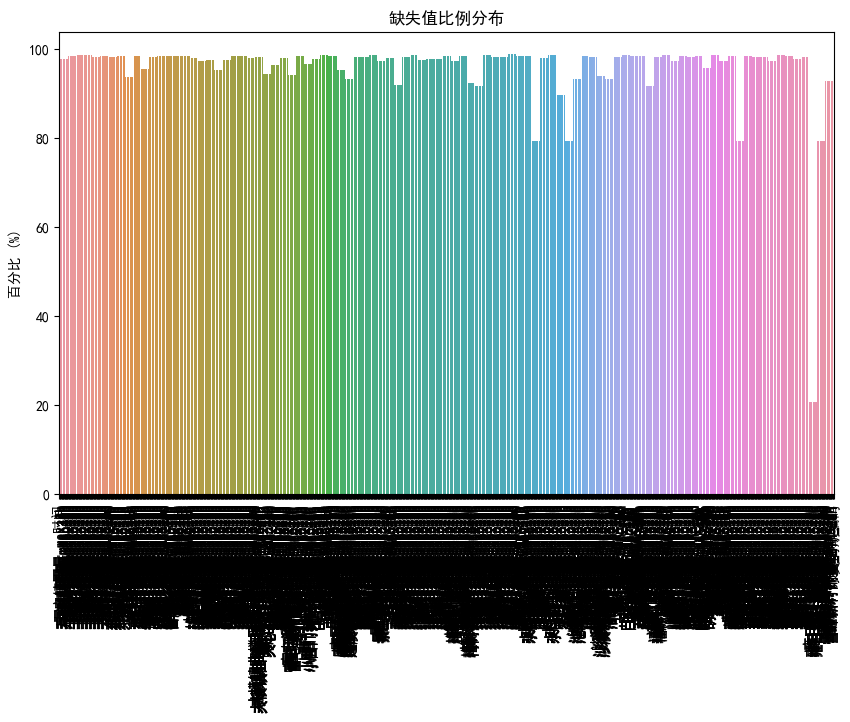

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=missing_percent.index, y=missing_percent)
plt.xticks(rotation=90)
plt.title('缺失值比例分布')
plt.ylabel('百分比 (%)')
plt.show()

In [ ]:
df_train

时间  万安镇雨量_max_1h  万安镇雨量_max_3h  万安镇雨量_max_6h  \
0     2014-01-01 00:00:00           NaN           NaN           NaN   
1     2014-01-01 01:00:00           NaN           NaN           NaN   
2     2014-01-01 02:00:00           NaN           NaN           NaN   
3     2014-01-01 03:00:00           NaN           NaN           NaN   
4     2014-01-01 04:00:00           NaN           NaN           NaN   
...                   ...           ...           ...           ...   
52579 2019-12-31 19:00:00           NaN           NaN           NaN   
52580 2019-12-31 20:00:00           NaN           NaN           NaN   
52581 2019-12-31 21:00:00           NaN           NaN           NaN   
52582 2019-12-31 22:00:00           NaN           NaN           NaN   
52583 2019-12-31 23:00:00           NaN           NaN           NaN   

       万安镇雨量_max_12h  万安镇雨量_max_24h  万安镇雨量_max_36h  万安镇雨量_max_48h  \
0                NaN            NaN            NaN            NaN   
1                NaN            NaN            NaN            NaN   
2                NaN            NaN            NaN            NaN   
3                NaN            NaN            NaN            NaN   
4                NaN            NaN            NaN            NaN   
...              ...            ...            ...            ...   
52579            NaN            NaN            NaN            NaN   
52580            NaN            NaN            NaN            NaN   
52581            NaN            NaN            NaN            NaN   
52582            NaN            NaN            NaN            NaN   
52583            NaN            NaN            NaN            NaN   

       万安镇雨量_min_1h  万安镇雨量_min_3h  万安镇雨量_min_6h  万安镇雨量_min_12h  万安镇雨量_min_24h  \
0               NaN           NaN           NaN            NaN            NaN   
1               NaN           NaN           NaN            NaN            NaN   
2               NaN           NaN           NaN            NaN            NaN   
3               NaN           NaN           NaN            NaN            NaN   
4               NaN           NaN           NaN            NaN            NaN   
...             ...           ...           ...            ...            ...   
52579           NaN           NaN           NaN            NaN            NaN   
52580           NaN           NaN           NaN            NaN            NaN   
52581           NaN           NaN           NaN            NaN            NaN   
52582           NaN           NaN           NaN            NaN            NaN   
52583           NaN           NaN           NaN            NaN            NaN   

       万安镇雨量_min_36h  万安镇雨量_min_48h  下保村雨量_max_1h  下保村雨量_max_3h  下保村雨量_max_6h  \
0                NaN            NaN           NaN           NaN           NaN   
1                NaN            NaN           NaN           NaN           NaN   
2                NaN            NaN           NaN           NaN           NaN   
3                NaN            NaN           NaN           NaN           NaN   
4                NaN            NaN           NaN           NaN           NaN   
...              ...            ...           ...           ...           ...   
52579            NaN            NaN           NaN           NaN           NaN   
52580            NaN            NaN           NaN           NaN           NaN   
52581            NaN            NaN           NaN           NaN           NaN   
52582            NaN            NaN           NaN           NaN           NaN   
52583            NaN            NaN           NaN           NaN           NaN   

       下保村雨量_max_12h  下保村雨量_max_24h  下保村雨量_max_36h  下保村雨量_max_48h  \
0                NaN            NaN            NaN            NaN   
1                NaN            NaN            NaN            NaN   
2                NaN            NaN            NaN            NaN   
3                NaN            NaN            NaN            NaN   
4                NaN            NaN            NaN